In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from vae_interp.dataset import NpyDataset
from vae_interp.vae import VAE
import matplotlib.pyplot as plt
import torch
from vae_interp.sae import SAE

/home/ubuntu/.cache/pypoetry/virtualenvs/nouns-mech-interp-YeAXWnnL-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
npy_path = "./vae_embeddings.npy"
dataset = NpyDataset(npy_path)

len(dataset)

49859

In [4]:
vae_checkpoint = "./checkpoints/vae"

vae = VAE.load_from_dir(vae_checkpoint)
vae.to("cuda")

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (mu_logvar): Conv2d(256, 8, kernel_siz

In [5]:
dataset[0]

tensor([ 0.3580, -0.7584, -0.7236,  0.2047,  0.4342, -1.0282, -0.5373, -0.3994,
         0.3159,  0.2271,  3.2967, -0.1082,  0.4442, -1.3350,  0.1087, -0.0599,
        -0.1499, -1.4915, -1.1173, -1.1423, -0.7139,  0.3007,  1.9337, -0.5247,
        -0.9506,  1.5348,  1.3062, -0.1191, -0.6700, -0.8807,  0.7381, -0.3178,
        -0.7549,  0.8090, -1.6190, -0.4869, -0.8433, -0.1409,  0.1760, -0.8304,
        -0.9876,  1.4467,  0.5713, -0.5600, -1.0598,  1.9426, -0.2219, -0.9749,
         0.4190,  0.1557, -1.1312,  0.3236,  0.4938, -1.1100, -0.1721,  1.0031,
         0.2506,  0.7770, -1.8356,  0.3198,  0.2038, -0.9374, -1.2771,  0.7020])

In [6]:
# sanity check to make sure it decodes to the right image with VAE
embedding = dataset[1].view(4, 4, 4).unsqueeze(0).to("cuda")
embedding.shape

torch.Size([1, 4, 4, 4])

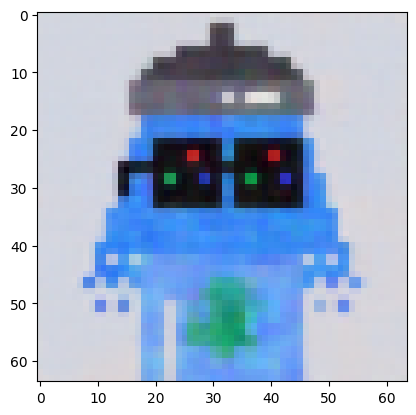

In [7]:
vae.eval()
with torch.no_grad():
    recon = vae.decode(embedding)
    recon = recon.cpu().squeeze(0).permute(1, 2, 0)
    recon = img = (recon - recon.min()) / (recon.max() - recon.min())

plt.imshow(recon)

In [8]:
sae = SAE(
    in_features=4**3,
    expansion_factor=2
)

sae.to("cuda")

SAE()

In [9]:
batch = dataset[0].unsqueeze(0).to("cuda")

In [10]:
sae(batch)

SAEOutput(recon=tensor([[ 0.0711,  1.5868,  0.7633, -0.8628, -0.1403,  0.1755,  0.1580,  0.7100,
         -0.0723,  0.2367,  0.7315,  0.7535, -0.1749, -0.6190,  0.0771, -1.5686,
         -0.4475,  2.2040, -0.2919, -1.0032,  0.2462, -0.4266,  1.8615, -0.3575,
          0.0217, -1.3702, -1.0967,  0.4749,  1.0128, -0.6127, -0.4240, -0.7062,
         -0.3467,  0.6309,  0.3617,  0.5954, -1.5546,  0.1606, -0.4594, -1.5715,
         -0.3665,  0.4776,  0.3732,  0.4307,  0.9025, -1.1864,  0.2804, -1.6341,
         -0.9731,  1.4593,  1.0354, -1.5053, -0.2297,  0.0320,  1.1273,  0.1478,
         -0.3813, -0.4867,  0.1950,  0.6573,  0.5739, -0.4530,  0.3191,  0.3384]],
       device='cuda:0', grad_fn=<AddBackward0>), latent=tensor([[0.0000, 0.0000, 0.4031, 0.0000, 0.0000, 0.0000, 0.1859, 0.0000, 0.0000,
         0.1483, 0.6097, 1.2580, 0.0000, 1.0550, 0.2693, 0.0000, 0.0000, 0.0000,
         0.0000, 1.9407, 1.7645, 0.2915, 0.3944, 0.0000, 0.2240, 0.9439, 0.1265,
         0.0000, 0.0000, 0.0000, 0.

In [13]:
sae.loss(batch, 0.1)

tensor(6.1500, device='cuda:0', grad_fn=<AddBackward0>)

In [66]:
from torch.utils.data import DataLoader
from vae_interp.trainer import SAETrainConfig, SAETrainer


dataset = NpyDataset("./vae_embeddings.npy")
dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)

sae = SAE(
    in_features=64,
    expansion_factor=8,
    dtype=torch.float32,
)

train_config = SAETrainConfig(
    lr=3e-4,
    iterations=10,
    lmbda=0.004,
)
trainer = SAETrainer(
    model=sae,
    dataloader=dataloader,
    config=train_config,
    save_dir="./checkpoints/sae",
    checkpoint_every=10,
    # device=args.device,
)

In [67]:
trainer.get_l0_norm()

Computing L0 norm:   9%|▉         | 36/390 [00:00<00:00, 357.31it/s]

Computing L0 norm: 100%|██████████| 390/390 [00:00<00:00, 1066.99it/s]


254.1637417517399

In [68]:
trainer.get_feature_density()

Computing feature densities:   4%|▍         | 16/390 [00:00<00:02, 159.63it/s]

Computing feature densities: 100%|██████████| 390/390 [00:00<00:00, 992.28it/s] 


tensor([3.2883e-01, 6.9129e-01, 5.8746e-02, 5.5984e-01, 8.8187e-01, 9.2693e-01,
        8.9619e-01, 8.7429e-01, 9.7595e-01, 7.7218e-02, 5.4454e-02, 8.8129e-02,
        7.9300e-01, 4.5771e-01, 9.5684e-01, 9.9396e-01, 9.3303e-01, 1.2489e-01,
        4.3723e-03, 9.5481e-01, 1.2435e-03, 7.4803e-01, 2.9940e-01, 4.1317e-03,
        6.4606e-01, 1.8562e-01, 9.6494e-01, 6.8700e-01, 7.6093e-01, 2.5612e-02,
        9.9898e-01, 7.3714e-01, 2.8861e-02, 6.8654e-01, 1.0229e-02, 9.8983e-01,
        5.0613e-01, 5.2889e-01, 5.9624e-01, 5.6385e-01, 5.7667e-01, 3.2008e-01,
        4.9788e-01, 3.3675e-01, 1.7136e-01, 3.0185e-02, 5.3832e-01, 4.4899e-01,
        3.1890e-03, 3.5967e-01, 9.2328e-01, 1.0837e-01, 3.4096e-04, 5.1630e-01,
        3.1070e-01, 0.0000e+00, 3.9299e-01, 3.4285e-01, 2.7971e-01, 9.3115e-01,
        1.8219e-01, 7.8562e-02, 1.9726e-01, 9.1725e-01, 1.0000e+00, 1.0209e-02,
        3.4979e-02, 8.1815e-01, 5.8828e-01, 6.2171e-01, 3.4088e-01, 3.8787e-01,
        4.4124e-02, 6.2073e-01, 2.9758e-

Computing feature densities:  10%|▉         | 38/390 [00:00<00:00, 378.62it/s]

Computing feature densities: 100%|██████████| 390/390 [00:00<00:00, 1003.56it/s]


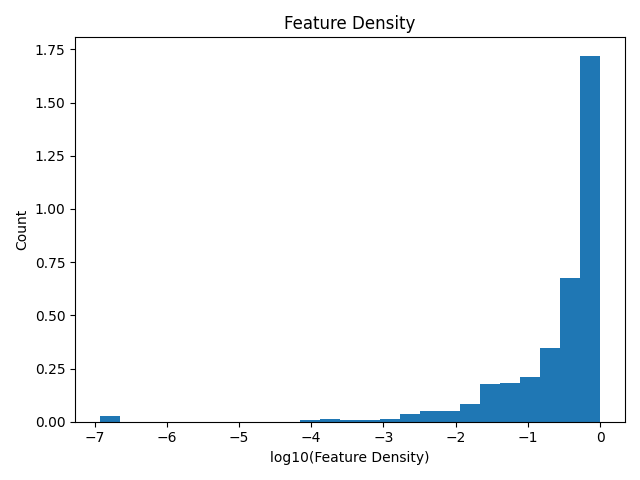

In [69]:
trainer.get_log_feature_density_plot()